In [12]:
import sys
sys.path.insert(1, '..')
from utils import *
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from scipy.stats import gmean

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path'] 
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']
AREA_NAME = 'NYC'

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

In [3]:
def get_cbg_locs(selected_cbgs=None):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    
    if isinstance(selected_cbgs, str):
        base_df = base_df[base_df.GEOID.str[:5] == selected_cbgs]
    elif isinstance(selected_cbgs, set):
        base_df = base_df[base_df.GEOID.isin(selected_cbgs)]
    
    base_df['centroid_lon'] = base_df.geometry.centroid.x
    base_df['centroid_lat'] = base_df.geometry.centroid.y
    cbg_locs = base_df[['GEOID', 'centroid_lat', 'centroid_lon']].set_index('GEOID')
    
    return cbg_locs

In [4]:
def get_poi_locs(poi_cat=None):
    poi_dir = join(pwd, dpath, 'area-pois', AREA_NAME)
    dfs = []
    for f in os.listdir(poi_dir):
        df = pd.read_csv(join(poi_dir, f))
        if poi_cat:
            df = df[df['top_category'] == poi_cat]
        dfs.append(df)

    df = pd.concat(dfs).drop_duplicates(subset=['safegraph_place_id'])

    poi_locs = df[['safegraph_place_id', 'latitude', 'longitude']].set_index('safegraph_place_id')
    return poi_locs

In [5]:
def match_poi2cbg(poi_locs):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    base_df = base_df[['GEOID', 'geometry']]
    
    gdf = gpd.GeoDataFrame(poi_locs.copy(), geometry=gpd.points_from_xy(poi_locs.longitude, poi_locs.latitude))
    
    return gpd.sjoin(gdf, base_df, how='inner', op='within')

In [6]:
def get_nvisits(row, cbg_visits, keys, visit_records, seen_cbg_poi_pairs):
    poi = row['safegraph_place_id']
    entries = json.loads(row['visitor_home_cbgs'])
    for cbg in entries.keys():
        visits = {'poi': poi}
        if cbg in keys:
            cbg_visits.loc[cbg, 'nvisits'] += entries[cbg]
            visits['cbg'] = cbg
            visits['nvisits'] = entries[cbg]
            seen_cbg_poi_pairs.add('-'.join([poi, cbg]))
            visit_records.append(visits)

In [7]:
def agg_visits_by_cbgs(distance_mat, pattern_dir, pattern_files=None):
    cbg_visits = pd.DataFrame(np.zeros(distance_mat.shape[0]), index=distance_mat.index, columns=['nvisits'])
    cbg_lookup = set(distance_mat.index)
    poi_lookup = set(distance_mat.columns)
    visit_records = []
    seen_cbg_poi_pairs = set()
    
    if not pattern_files:
        pattern_files = os.listdir(pattern_dir)
    
    for f in tqdm(pattern_files):
        df = pd.read_csv(join(pattern_dir, f))
        df = df[df.safegraph_place_id.isin(poi_lookup)]
        df.apply(get_nvisits, cbg_visits=cbg_visits, keys=cbg_lookup, axis=1, visit_records=visit_records, seen_cbg_poi_pairs=seen_cbg_poi_pairs)
        
    for cbg in tqdm(cbg_lookup):
        for poi in poi_lookup:
            if '-'.join([poi, cbg]) not in seen_cbg_poi_pairs:
                visit_records.append({
                    'poi': poi,
                    'cbg': cbg,
                    'nvisits': 0
                })

    return pd.DataFrame(visit_records).set_index('cbg')

In [8]:
def get_spreader_cbgs(pct=0.75):
    spreader_cbgs = pd.read_csv(join(pwd, util_datasets, 'nyc_spreader_rank.csv'))
    return spreader_cbgs[spreader_cbgs['rank'] >= pct].cbg.astype(str).values

def gen_rand_loc(c_lat, c_lng, r=1000):
    # https://github.com/rmrs/random-location/blob/master/src/index.js
    sin_lat = np.sin(np.radians(c_lat))
    cos_lat = np.cos(np.radians(c_lat))
    
    bearing = np.random.rand() * np.pi * 2
    sin_bearing = np.sin(bearing)
    cos_bearing = np.cos(bearing)
    
    t = r / 6371000
    sint = np.sin(t)
    cost = np.cos(t)
    
    rlat = np.arcsin(sin_lat * cost + cos_lat * sint * cos_bearing)
    rlng = np.radians(c_lng) + np.arctan2(sin_bearing * sint * cos_lat, cost - sin_lat * np.sin(rlat))
    rlng = ((rlng + np.pi*3) % (np.pi*2)) - np.pi;
    
    to_deg = lambda rad: rad / (np.pi / 180)
    
    return [to_deg(rlat), to_deg(rlng)]

In [183]:
def ols_alpha(agg_visits, d_alpha):
    alphas = {}
    r2 = []
    p = []
    for cbg in tqdm(agg_visits.index.unique()):
        cbg_records = agg_visits.loc[cbg].set_index('poi')
        cbg_records['nvisits'] /= cbg_records['nvisits'].sum()
        cbg_records['nvisits'] += 1e-8
        cbg_records['d_alpha'] = 0
        
        # find P_ij / P_i^hat (geometric mean of P_i^hat)
        cbg_records['nvisits'] /= gmean(cbg_records['nvisits'])
        # geometric mean of distances
        D_gmean = gmean(d_alpha.loc[cbg])

        for ind in cbg_records.index:
            cbg_records.loc[ind, 'd_alpha'] = d_alpha.loc[cbg, ind] / D_gmean

        reg_table = np.log(cbg_records)
        #reg_table = sm.add_constant(reg_table, prepend=False, has_constant='add')

        model = sm.OLS(reg_table['nvisits'], reg_table[['d_alpha']])
        results = model.fit()
        #print(results.summary())
        alpha = results.params[0]
        alphas[cbg] = alpha
        r2.append(results.rsquared)
        p.append(results.pvalues[0])
    
    return alphas, r2, p

In [184]:
def comp_dist_matrix(cbg_locs, poi_locs, alphas=None):
    dist_matrix = pd.DataFrame(haversine_distances(np.radians(cbg_locs), np.radians(poi_locs)) * 6371, index=cbg_locs.index, columns=poi_locs.index)
    
    if alphas:
        #dist_matrix = 1/dist_matrix

        for cbg, alpha in alphas.items():
            dist_matrix.loc[cbg] *= alpha

        return dist_matrix.div(dist_matrix.sum(axis=1), axis=0)
    
    return dist_matrix

In [185]:
borough = 'Staten Island'
selected_cbsg = str(nyc_borough2fips[borough])
cbg_locs = get_cbg_locs(selected_cbgs=selected_cbsg)

poi_cat = 'Grocery Stores'
poi_locs = get_poi_locs(poi_cat=poi_cat)

poi_cbg_ids = match_poi2cbg(poi_locs)

In [194]:
pattern_dir = join(pwd, dpath, 'filtered-patterns-msa', 'NYC-patterns')
# patterns = ['2020-03-23.csv', '2020-03-30.csv', '2020-04-06.csv', '2020-04-13.csv', 
#             '2020-04-20.csv', '2020-04-27.csv', '2020-05-04.csv', '2020-05-11.csv', 
#             '2020-05-18.csv', '2020-05-25.csv', '2020-06-01.csv']

patterns = os.listdir(pattern_dir)[:15]

poi_cbg_visits = agg_visits_by_cbgs(d_alpha, pattern_dir, pattern_files=patterns)
poi_cbg_visits = poi_cbg_visits[poi_cbg_visits.nvisits > 0]

100%|██████████████████████████████████████████████████████████████████████████████| 306/306 [00:00<00:00, 1810.65it/s]


In [195]:
poi_locs = poi_locs.loc[poi_cbg_visits.poi.unique()]
cbg_locs = cbg_locs.loc[poi_cbg_visits.index.unique()]
d_alpha = comp_dist_matrix(cbg_locs, poi_locs)

In [191]:
len(poi_cbg_visits.index), len(poi_cbg_visits.index.unique())

(23456, 306)

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:11<00:00, 26.88it/s]


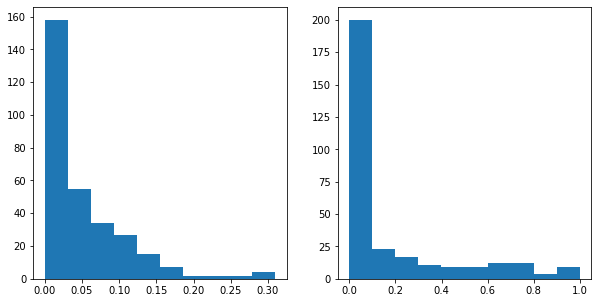

In [196]:
alpha_params, r2, p = ols_alpha(poi_cbg_visits, d_alpha)

save_dir = join(RESULT_SAVE_DIR, 'huff-params')
if not exists(save_dir):
    os.mkdir(save_dir)

with open(join(save_dir, f'{borough}-params.json'), 'w') as f:
    json.dump(alpha_params, f)
    
fig, axes = plt.subplots(1,2,figsize=(10, 5))

r2ax = axes[0]
r2ax.hist(r2)

pax = axes[1]
pax.hist(p);

In [163]:
with open(join(save_dir, f'{borough}-params.json'), 'r') as f:
    alpha_params = json.load(f)

In [164]:
rand_gen_poi_locs = []
for cbg in cbg_locs.index:
    entry = cbg_locs.loc[cbg]
    rand_gen_poi_locs.append(gen_rand_loc(entry['centroid_lat'], entry['centroid_lon'], r=1000))
    
rand_gen_poi_locs = pd.DataFrame(rand_gen_poi_locs, columns=poi_locs.columns)

In [165]:
sim_poi_locs = pd.concat([poi_locs, rand_gen_poi_locs])
sim_d_alpha = comp_dist_matrix(cbg_locs, sim_poi_locs, alphas=alpha_params)

In [166]:
# total visits by each cbg
total_cbg_visits = poi_cbg_visits.groupby(poi_cbg_visits.index).nvisits.sum().loc[sim_d_alpha.index]
# multiply total visits by dist^-alpha (with hypothetical pois)
sim_visits2pois = sim_d_alpha.mul(total_cbg_visits.values, axis=0).sum(axis=0)
# get the actual visits for each poi
actual_poi_visits = poi_cbg_visits.groupby('poi').nvisits.sum()
# and also the actual set of pois
# actual_visits2pois = d_alpha.mul(total_cbg_visits.values, axis=0).sum(axis=0)
# find the difference between simulation and actual setting
nonzero_actual_visits = actual_poi_visits[actual_poi_visits > 0]
sim_diff = (sim_visits2pois.loc[nonzero_actual_visits.index] - nonzero_actual_visits) / nonzero_actual_visits

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['360850154001', '360850223003'], dtype='object', name='GEOID'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [70]:
# spreader cbgs ordered by occurrence rank
spreader_cbgs = set(get_spreader_cbgs(pct=0.75))
# find the pois in those cbgs
pois_in_spreader_cbgs = poi_cbg_ids[poi_cbg_ids.GEOID.isin(spreader_cbgs)].index
# and the rest of the pois
other_pois = poi_cbg_ids[~poi_cbg_ids.GEOID.isin(spreader_cbgs)].index
# pct change for spreader cbgs
print(f'Change in visits for spreader CBGS: {sim_diff[pois_in_spreader_cbgs].sum() / actual_visits2pois.loc[pois_in_spreader_cbgs].sum()*100:.4f}%')
# and pct change for the remaining cbgs
print(f'Change in visits for other CBGS: {sim_diff[other_pois].sum() / actual_visits2pois.loc[other_pois].sum()*100:.4f}%')

Change in visits for spreader CBGS: -0.0026%
Change in visits for other CBGS: 0.0001%


In [88]:
kk = actual_poi_visits[actual_poi_visits > 0]
x = sim_visits2pois.loc[kk.index] - kk

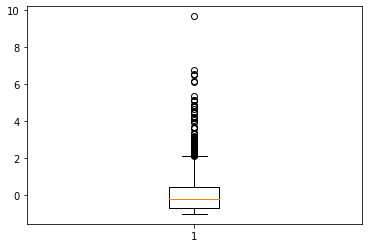

In [98]:
plt.boxplot(x / kk);